## Notebook purpose

Rethinking author claims that overparameterized models wouldn’t work for non-bayesian models. My interpretation of this is that informative priors can be used to get a posterior back that has probability mass concentrated at one solution (or something??). However the author also mentions that for categorical models we only need K-1 models; the last model can be a pivot by setting it to 0. Here I check whether such models can be overparameterized as well. The added benefit is easier to interpret parameters. Python code stolen from [here](https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_11.ipynb).  

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import theano.tensor as tt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import softmax

### Data

Simulate career choices based on family income. There is a unique intercept & coefficient for each career.

In [2]:
a = np.array([0.5, 1.0, 1.5])
b = np.array([-2.0, 0.0, 2.0])

In [3]:
def simulate(n):
    # Simulate family income for each individual
    family_income = np.random.rand(n)
    
    # Generate scores and then softmax to probs
    s = a[:, None] + np.outer(b, family_income)
    p = softmax(s, axis=0).T

    # Sample careers based on probs
    career = np.asarray([np.random.multinomial(1, pp) for pp in p])
    career = np.where(career == 1)[1] # Alternatively, career.argmax(1)
    
    return family_income, s.T, p, career

Example.

In [4]:
n = 10_000
income, s, p, career = simulate(n)
income[:5], career[:5]

(array([0.32091506, 0.31448034, 0.79108643, 0.92282768, 0.21391849]),
 array([1, 2, 2, 2, 1]))

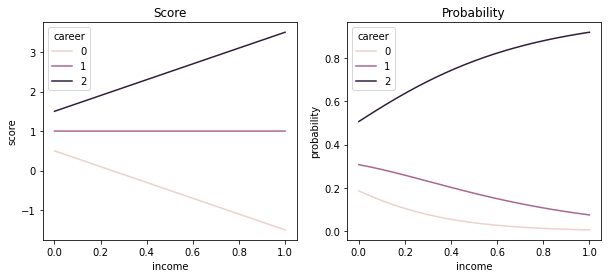

In [5]:
df = pd.DataFrame(dict(income=income))
df_prob = pd.concat([df, pd.DataFrame(p)], axis=1)\
    .melt('income', var_name='career', value_name='probability')
df_score = pd.concat([df, pd.DataFrame(s)], axis=1)\
    .melt('income', var_name='career', value_name='score')

fig, axs = plt.subplots(figsize=(10, 4), ncols=2)
axs[0].set_title('Score')
sns.lineplot(data=df_score, x="income", y="score", hue="career", ax=axs[0])
axs[1].set_title('Probability')
sns.lineplot(data=df_prob, x="income", y="probability", hue="career", ax=axs[1]);

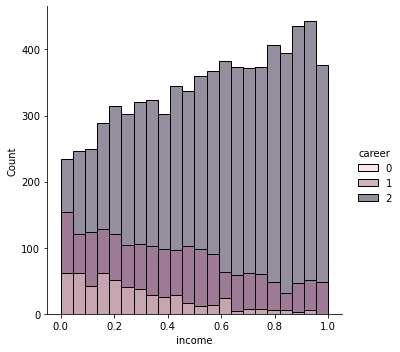

In [6]:
sns.displot(data=pd.DataFrame(dict(income=income, career=career)), 
            x='income', hue='career');

### Models

Model with pivot only recovers params for 2 careers.

In [7]:
def generate_pivot_model(income, career):
    with pm.Model() as model:
        a_ = pm.Normal('a', 0.0, 1.5, shape=2) 
        b_ = pm.Normal('b', 0.0, 1.0, shape=2)

        s0 = a_[0] + b_[0] * income
        s1 = a_[1] + b_[1] * income
        s2 = np.zeros(income.size) # pivot
        s = pm.math.stack([s0, s1, s2]).T

        p_ = tt.nnet.softmax(s)
        pm.Categorical('y', p=p_, observed=career)
    return model

Model without pivot is overparameterized. Recovers param for all three careers.

In [8]:
def generate_overparam_model(income, career):
    with pm.Model() as model:
        a_ = pm.Normal('a', 0.0, 1.5, shape=3) 
        b_ = pm.Normal('b', 0.0, 1.0, shape=3)

        s0 = a_[0] + b_[0] * income
        s1 = a_[1] + b_[1] * income
        s2 = a_[2] + b_[2] * income
        s = pm.math.stack([s0, s1, s2]).T

        p_ = tt.nnet.softmax(s)
        pm.Categorical('y', p=p_, observed=career)
    return model

### Inference

Sample from posterior of both models for different sample sizes.

In [9]:
ns = [50, 100, 500, 2_000]
pivot_traces = []
overparam_traces = []

for n in ns:
    income, s, p, career = simulate(n)
    with generate_pivot_model(income, career):
        pivot_traces.append(pm.sample(return_inferencedata=False))
    with generate_overparam_model(income, career):
        overparam_traces.append(pm.sample(return_inferencedata=False))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
The acceptance probability does not match the target. It is 0.8890195049820658, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
The acceptance probability does not match the target. It is 0.8886950023974198, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.


Note that the overparam gets much slower with more data. There are also divergences, low number of effective samples, and bad acceptance probabilities.

### Posteriors

Visualize param posteriors. For the pivot model we cannot compare to true param values. (Or can we? Essentialy a=0 and b=0 for pivot)

/home/mochar/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/mochar/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/mochar/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.


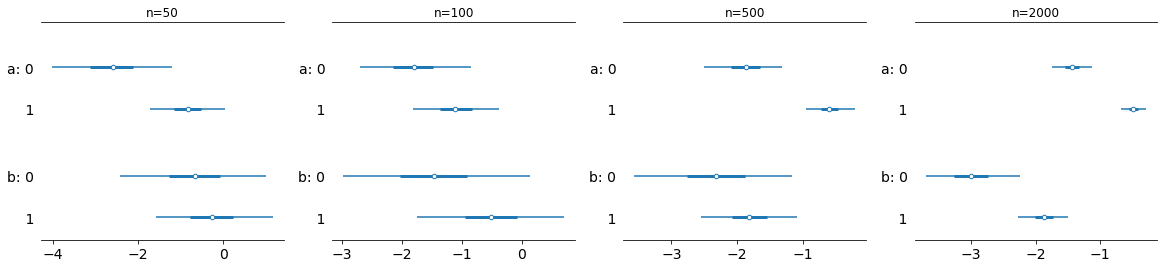

In [10]:
fig, axs = plt.subplots(figsize=(20, 4), ncols=len(ns))
for i, n in enumerate(ns):
    pm.plot_forest(pivot_traces[i], combined=True, ax=axs[i]);
    axs[i].set_title(f'n={n}')

For the overparam model we can directly compare inferred params with true params. We see that it recovers them OK. This is nice for interpretability.

/home/mochar/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/mochar/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/mochar/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.


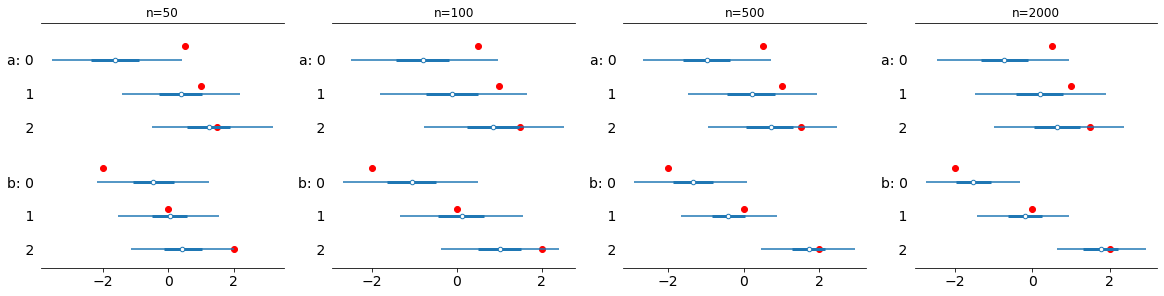

In [11]:
fig, axs = plt.subplots(figsize=(20, 4.5), ncols=len(ns))
for i, n in enumerate(ns):
    pm.plot_forest(overparam_traces[i], combined=True, ax=axs[i]);
    axs[i].scatter(np.r_[b[::-1], a[::-1]], range(6), c='r')
    axs[i].set_title(f'n={n}')

The overparam model struggles because of a bad posterior geometry (?????). Because the third intercept and coefficient are unnecessary, there is a strong correlation between the intercepts and coefficients as many configurations can recover the data. Because we have set non-flat priors on these parameters the model can still sample. This is similar to the model with left and right leg length as predictors.

/home/mochar/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


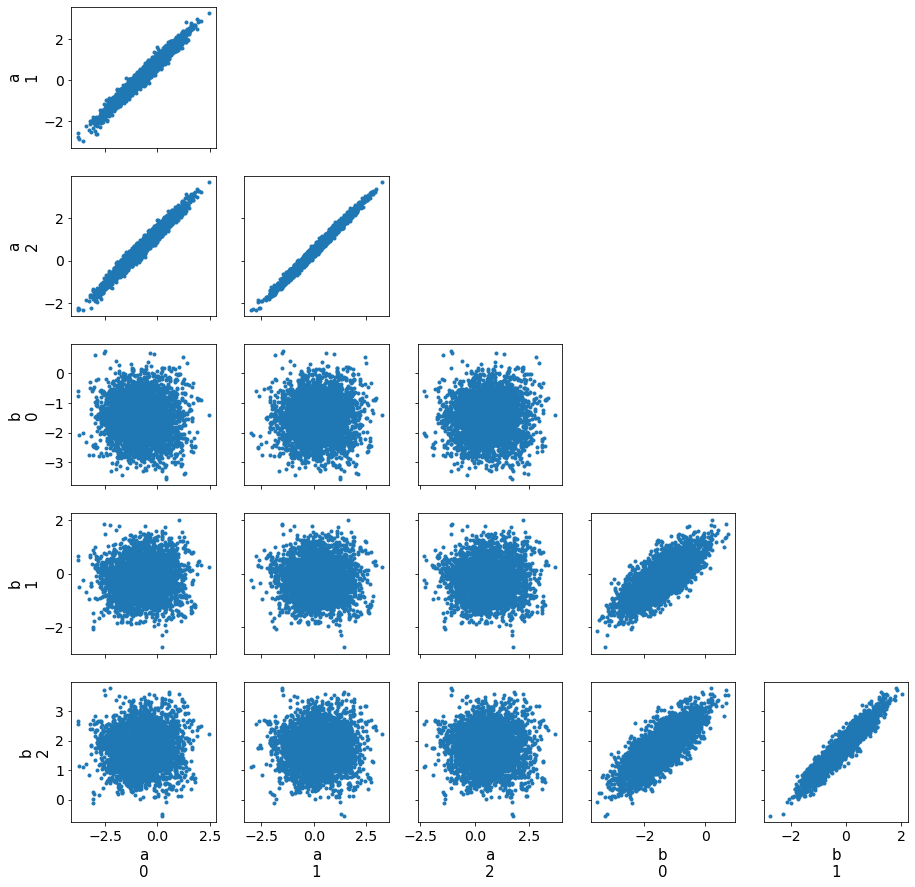

In [43]:
az.plot_pair(overparam_traces[3], figsize=(15, 15));

There is no correlation between intercepts and between coefficients in the pivot model. There is a correlation between the intercept and coefficient within each career. That's because they are indeed correlated (b increases with a). Chapter 14 talks about modelling such correlations with multivariate normal priors.

/home/mochar/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


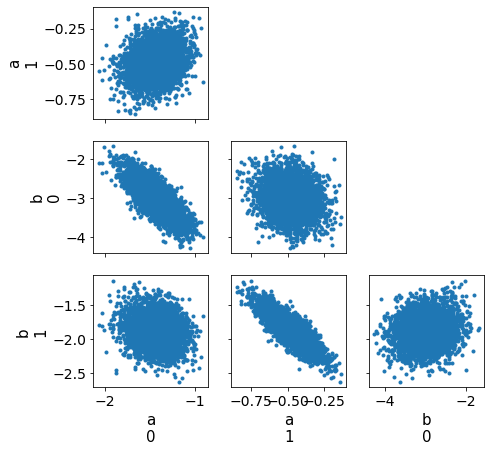

In [44]:
az.plot_pair(pivot_traces[3], figsize=(7, 7));